
## NYC Taxi Trip Analytics with PySpark

Environment Setup: Java, Spark, and Findspark

In [2]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install findspark
!pip install -q findspark

In [3]:
# Install PySpark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Streaming Project") \
    .getOrCreate()

# Verify Spark session
spark

Data Cleaning & Preprocessing

In [4]:
import pandas as pd
import time
from pyspark.sql.functions import col, to_timestamp

In [5]:
# NYC Taxi data (Jan 2021)
url = "https://github.com/DataTalksClub/nyc-tlc-data/releases/download/yellow/yellow_tripdata_2021-01.csv.gz"


In [6]:
chunksize = 10000  # rows per "stream"
stream_count = 0

for chunk in pd.read_csv(url, chunksize=chunksize):
    stream_count += 1
    print(f"\n Streaming Batch {stream_count}")

    # Convert to Spark DataFrame
    sdf = spark.createDataFrame(chunk)

    # Rename columns to lowercase for consistency
    for col_name in sdf.columns:
        sdf = sdf.withColumnRenamed(col_name, col_name.lower())

    # Convert pickup and dropoff to timestamp
    sdf = sdf.withColumn("pickup_datetime", to_timestamp(col("tpep_pickup_datetime"))) \
             .withColumn("dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

    # Drop rows with nulls in important columns
    sdf = sdf.dropna(subset=["pickup_datetime", "dropoff_datetime", "passenger_count", "trip_distance", "total_amount"])

    # Filter invalid/irrelevant trips
    sdf = sdf.filter((col("trip_distance") > 0) & (col("total_amount") > 0) & (col("passenger_count") > 0))

    # Preview cleaned batch
    sdf.select("pickup_datetime", "dropoff_datetime", "trip_distance", "passenger_count", "total_amount") \
       .show(5, truncate=False)

    # Simulate 2s delay like real-time streaming
    time.sleep(2)

    if stream_count == 3:
        print("✅ Cleaned and preprocessed 3 streamed batches.")
        break


 Streaming Batch 1
+-------------------+-------------------+-------------+---------------+------------+
|pickup_datetime    |dropoff_datetime   |trip_distance|passenger_count|total_amount|
+-------------------+-------------------+-------------+---------------+------------+
|2021-01-01 00:30:10|2021-01-01 00:36:12|2.1          |1              |11.8        |
|2021-01-01 00:51:20|2021-01-01 00:52:19|0.2          |1              |4.3         |
|2021-01-01 00:43:30|2021-01-01 01:11:06|14.7         |1              |51.95       |
|2021-01-01 00:31:49|2021-01-01 00:48:21|4.94         |1              |24.36       |
|2021-01-01 00:16:29|2021-01-01 00:24:30|1.6          |1              |14.15       |
+-------------------+-------------------+-------------+---------------+------------+
only showing top 5 rows


 Streaming Batch 2
+-------------------+-------------------+-------------+---------------+------------+
|pickup_datetime    |dropoff_datetime   |trip_distance|passenger_count|total_amount|


Feature Engineering

In [7]:
from pyspark.sql.functions import hour, dayofweek, month, when, unix_timestamp

In [8]:
# Extract time-based features
sdf = sdf.withColumn("pickup_hour", hour("pickup_datetime")) \
         .withColumn("pickup_day", dayofweek("pickup_datetime")) \
         .withColumn("pickup_month", month("pickup_datetime"))

# Rush hour flag: 7-9 AM and 4-7 PM weekdays
sdf = sdf.withColumn("rush_hour_flag", when(
    ((col("pickup_hour").between(7, 9)) | (col("pickup_hour").between(16, 19))) &
    (col("pickup_day").between(2, 6)), 1).otherwise(0)
)

# Trip duration in minutes
sdf = sdf.withColumn("trip_duration_min",
                     (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)

# Bucket distance
sdf = sdf.withColumn("distance_bucket", when(col("trip_distance") < 2, "short") \
                     .when(col("trip_distance").between(2, 5), "medium") \
                     .otherwise("long"))


In [9]:
# Preview engineered features
sdf.select("pickup_datetime", "pickup_hour", "pickup_day", "rush_hour_flag",
           "trip_distance", "trip_duration_min", "distance_bucket", "total_amount") \
   .show(10, truncate=False)

+-------------------+-----------+----------+--------------+-------------+------------------+---------------+------------+
|pickup_datetime    |pickup_hour|pickup_day|rush_hour_flag|trip_distance|trip_duration_min |distance_bucket|total_amount|
+-------------------+-----------+----------+--------------+-------------+------------------+---------------+------------+
|2021-01-01 19:09:37|19         |6         |1             |1.17         |5.333333333333333 |short          |11.62       |
|2021-01-01 19:42:28|19         |6         |1             |0.77         |3.683333333333333 |short          |7.8         |
|2021-01-01 19:09:54|19         |6         |1             |0.36         |1.3333333333333333|short          |6.3         |
|2021-01-01 19:13:56|19         |6         |1             |1.9          |8.566666666666666 |short          |14.16       |
|2021-01-01 19:54:48|19         |6         |1             |3.9          |18.233333333333334|medium         |22.56       |
|2021-01-01 19:06:09|19 

EDA

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import avg, count

In [11]:
# Aggregated Stats: Rush Hour vs Non-Rush
rush_stats = sdf.groupBy("rush_hour_flag") \
    .agg(avg("trip_distance").alias("avg_distance"),
         avg("total_amount").alias("avg_fare"),
         count("*").alias("trip_count"))

rush_stats.show()

+--------------+------------------+------------------+----------+
|rush_hour_flag|      avg_distance|          avg_fare|trip_count|
+--------------+------------------+------------------+----------+
|             1| 3.353746958637467|18.122043795620502|       411|
|             0|3.5818699010116357|18.349531165017662|      9193|
+--------------+------------------+------------------+----------+



In [12]:
# Convert to Pandas for Visuals
# Hourly trip count
hourly_df = sdf.groupBy("pickup_hour") \
    .count() \
    .orderBy("pickup_hour") \
    .toPandas()

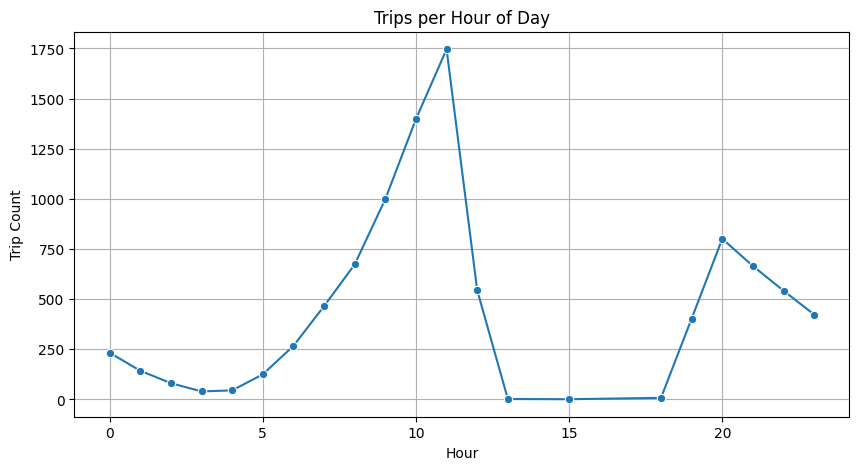

In [13]:
# Line plot for trip distribution by hour
plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_df, x="pickup_hour", y="count", marker="o")
plt.title("Trips per Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()

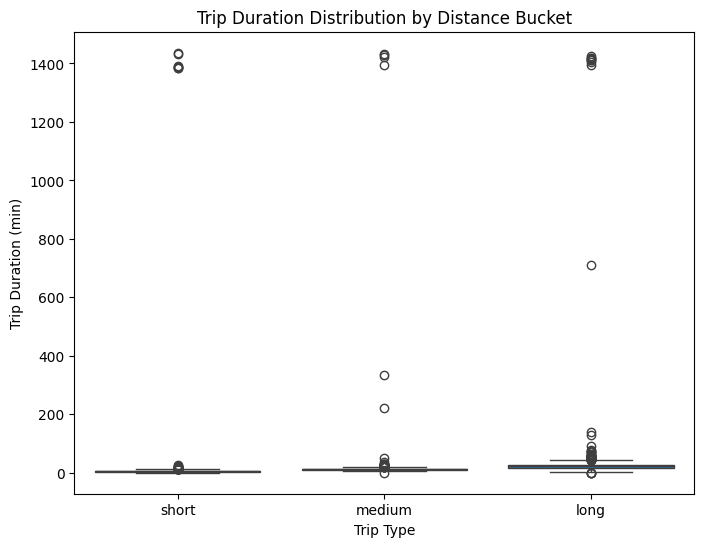

In [14]:
# Box Plot: Trip Duration by Distance Bucket
bucket_df = sdf.select("distance_bucket", "trip_duration_min") \
    .dropna() \
    .toPandas()

plt.figure(figsize=(8,6))
sns.boxplot(data=bucket_df, x="distance_bucket", y="trip_duration_min")
plt.title("Trip Duration Distribution by Distance Bucket")
plt.ylabel("Trip Duration (min)")
plt.xlabel("Trip Type")
plt.show()

Data Quality Checks & Validations

1. Null / Missing Value Check

In [15]:
from pyspark.sql.functions import col, count, when, isnan

In [16]:
null_nan_summary = sdf.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c + "_null_nan")
    if dict(sdf.dtypes)[c] in ('double', 'float') else
    count(when(col(c).isNull(), c)).alias(c + "_null")
    for c in sdf.columns
])
null_nan_summary.show()

+-------------+-------------------------+--------------------------+--------------------+----------------------+---------------+-----------------------+-----------------+-----------------+-----------------+--------------------+--------------+----------------+-------------------+---------------------+------------------------------+---------------------+-----------------------------+--------------------+---------------------+----------------+---------------+-----------------+-------------------+--------------------------+--------------------+
|vendorid_null|tpep_pickup_datetime_null|tpep_dropoff_datetime_null|passenger_count_null|trip_distance_null_nan|ratecodeid_null|store_and_fwd_flag_null|pulocationid_null|dolocationid_null|payment_type_null|fare_amount_null_nan|extra_null_nan|mta_tax_null_nan|tip_amount_null_nan|tolls_amount_null_nan|improvement_surcharge_null_nan|total_amount_null_nan|congestion_surcharge_null_nan|pickup_datetime_null|dropoff_datetime_null|pickup_hour_null|pickup_da

. Duplicate Record Check (based on pickup + dropoff + passenger count)

In [17]:
dup_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count"]

duplicate_count = sdf.groupBy(dup_cols).count().filter("count > 1").count()
print(f"🚨 Duplicate records found: {duplicate_count}")

🚨 Duplicate records found: 1


3. Schema Check

In [18]:
sdf.printSchema()

root
 |-- vendorid: long (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: long (nullable = true)
 |-- dolocationid: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |--

4. Basic Sanity Checks

In [19]:
sdf.filter((col("trip_distance") < 0) | (col("trip_duration_min") < 0)).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---------------+----------------+-----------+----------+------------+--------------+-----------------+---------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|pickup_datetime|dropoff_datetime|pickup_hour|pickup_day|pickup_month|rush_hour_flag|trip_duration_min|distance_bucket|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------

In [20]:
sdf.orderBy(col("total_amount").desc()).select("total_amount", "trip_distance", "trip_duration_min").show(5)


+------------+-------------+------------------+
|total_amount|trip_distance| trip_duration_min|
+------------+-------------+------------------+
|       228.3|        48.68|              56.9|
|       175.2|        35.45|             45.95|
|      152.35|        33.96|49.083333333333336|
|       133.8|         0.73|1.1166666666666667|
|      132.96|         38.7| 73.58333333333333|
+------------+-------------+------------------+
only showing top 5 rows



Save Cleaned Data to Parquet Format

Save the final data as Parquet, partitioned by year and month

In [21]:
from pyspark.sql.functions import year, month

In [22]:
# Extract Year and Month for Partitioning
sdf = sdf.withColumn("pickup_year", year("tpep_pickup_datetime")) \
         .withColumn("pickup_month", month("tpep_pickup_datetime"))

In [23]:
# Save Final Enriched Data in Partitioned Parquet
output_path = "/content/nyc_yellow_tripdata_parquet"

sdf.write \
  .partitionBy("pickup_year", "pickup_month") \
  .mode("overwrite") \
  .parquet(output_path)

print("✅ Parquet files saved at:", output_path)

✅ Parquet files saved at: /content/nyc_yellow_tripdata_parquet


Check Folder Structure

In [24]:
import os

# Show a few files from the saved path
for root, dirs, files in os.walk(output_path):
    for name in files:
        print(os.path.join(root, name))

/content/nyc_yellow_tripdata_parquet/_SUCCESS
/content/nyc_yellow_tripdata_parquet/._SUCCESS.crc
/content/nyc_yellow_tripdata_parquet/pickup_year=2021/pickup_month=1/part-00001-3f3943b5-2eb4-4c7c-84a4-056ff6ec1d4f.c000.snappy.parquet
/content/nyc_yellow_tripdata_parquet/pickup_year=2021/pickup_month=1/.part-00000-3f3943b5-2eb4-4c7c-84a4-056ff6ec1d4f.c000.snappy.parquet.crc
/content/nyc_yellow_tripdata_parquet/pickup_year=2021/pickup_month=1/part-00000-3f3943b5-2eb4-4c7c-84a4-056ff6ec1d4f.c000.snappy.parquet
/content/nyc_yellow_tripdata_parquet/pickup_year=2021/pickup_month=1/.part-00001-3f3943b5-2eb4-4c7c-84a4-056ff6ec1d4f.c000.snappy.parquet.crc


Goal: Predict total_amount (Trip Fare)

Feature Selection

In [25]:
features = [
    "passenger_count",
    "trip_distance",
    "pulocationid",
    "dolocationid",
    "payment_type_indexed",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge"
]


Handle Categorical Features

In [26]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="payment_type", outputCol="payment_type_indexed")
sdf = indexer.fit(sdf).transform(sdf)


Assemble Features

In [27]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

final_data = assembler.transform(sdf).select("features", "total_amount")


Train-Test Split

In [28]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

Train Model (Linear Regression)

In [29]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="total_amount", featuresCol="features")
lr_model = lr.fit(train_data)


Evaluate

In [30]:
test_results = lr_model.evaluate(test_data)

print(f"RMSE: {test_results.rootMeanSquaredError}")
print(f"R²: {test_results.r2}")

RMSE: 0.8259092201374664
R²: 0.996918702449858


Save Model

In [31]:
model_path = "/content/nyc_fare_model"
lr_model.save(model_path)

The Linear Regression model shows excellent performance with an R² of 99.7%, meaning it explains 99.7% of the variation in trip fares. The RMSE of 0.83 indicates very low prediction error, confirming high accuracy.

Dashboard Integration

In [32]:
predictions = lr_model.transform(test_data)
predictions.select("features", "total_amount", "prediction").show(5)


+--------------------+------------+------------------+
|            features|total_amount|        prediction|
+--------------------+------------+------------------+
|(11,[0,1,2,3,4,10...|         0.3|0.3661856378288103|
|(11,[0,1,2,3,5,10...|        62.3|61.878227843960204|
|(11,[0,1,2,3,5,10...|        30.3|31.062951790741256|
|[1.0,0.02,41.0,41...|         4.8| 6.289179929574668|
|[1.0,0.03,151.0,1...|         6.8| 8.757114903179412|
+--------------------+------------+------------------+
only showing top 5 rows



In [33]:
#Export final DataFrame with predictions:

predictions.select("features", "total_amount", "prediction") \
    .write.mode("overwrite") \
    .parquet("/content/predicted_fares")

In [34]:
!zip -r predicted_fares.zip /content/predicted_fares


  adding: content/predicted_fares/ (stored 0%)
  adding: content/predicted_fares/part-00001-3552580e-bfe8-4104-bfab-3831c19793a6-c000.snappy.parquet (deflated 14%)
  adding: content/predicted_fares/part-00000-3552580e-bfe8-4104-bfab-3831c19793a6-c000.snappy.parquet (deflated 13%)
  adding: content/predicted_fares/_SUCCESS (stored 0%)
  adding: content/predicted_fares/._SUCCESS.crc (stored 0%)
  adding: content/predicted_fares/.part-00000-3552580e-bfe8-4104-bfab-3831c19793a6-c000.snappy.parquet.crc (stored 0%)
  adding: content/predicted_fares/.part-00001-3552580e-bfe8-4104-bfab-3831c19793a6-c000.snappy.parquet.crc (stored 0%)


In [35]:
# Convert Spark DataFrame to Pandas and Save as CSV
sdf.toPandas().to_csv("/content/predicted_fares.csv", index=False)
